# Not So Close Encounters

For as long as humans have existed there have been things in the sky that we've been unable to explain.
That list has gotten a lot smaller with certain inventions such as science, but there is still a fair amount out there we don't understand.
Some of that stuff we don't understand is esoteric, like dark matter and dark energy.
Some of it's a little closer to home.
People still see things in the sky they can't explain all the time.
Generally these types of things are pretty anecdotal, but get enough people to describe the same thing at the same time, or in the same place and you're looking at something that can't be so easily dismissed.

Recently I compiled and geocoded a collection of UFO sightings from the National UFO Reporting Center ([NUFORC](http://www.nuforc.org/)).
I made the data available on [data.world](https://data.world/timothyrenner/ufo-sightings) and put the code to get the data on [GitHub](https://github.com/timothyrenner/nuforc_sightings_data).
With this data and more I'll be able to look into a few basic questions about UFOs:
1. why are certain areas prone to UFO sightings?
2. when are UFOs seen throughout the year?
3. when were there highly corroborated UFO incidents?

![](http://1.bp.blogspot.com/-fOF1t2r7Fgk/TcW01yvCVrI/AAAAAAAAAA0/ttSOxTge3F8/s1600/ufo.jpg)

In [1]:
import datadotworld

Here's a quick look at what's in the dataset - what I'm most interested in is the text, sighting time, latitude and longitude.
As a first step I'm going to plot them on a map so I can get a feel for where these occur the most often and see if there are any obvious patterns.

These are the first few rows.

In [2]:
ufo_sightings_dataset = datadotworld.load_dataset(
    'timothyrenner/ufo-sightings'
)

ufo_sightings = \
    ufo_sightings_dataset\
        .dataframes['nuforc_reports']\
        .rename(columns={"shape": "reported_shape"})\
        .drop('city_location', axis=1)

ufo_sightings.head()

,summary,city,state,date_time,reported_shape,duration,stats,report_link,text,posted,city_latitude,city_longitude
0,"Three saucer shaped ships. High in the sky, m...",Salem,OR,NaT,disk,15 minutes,Occurred : 8/15/1950 14:00 (Entered as : 08/1...,http://www.nuforc.org/webreports/135/S135871.html,"Three saucer shaped ships. High in the sky, m...",NaT,44.941247,-123.004235
1,Tear-drop shaped silent craft with sectional f...,Ellsworth,ME,NaT,teardrop,5 minutes,Occurred : 8/15/1967 21:30 (Entered as : 08/0...,http://www.nuforc.org/webreports/132/S132451.html,Tear-drop shaped silent craft with sectional f...,NaT,44.651300,-68.450700
2,Green orb shot out of white light ((NUFORC No...,San Antonio,TX,2017-01-25 20:45:00,light,90 minutes,Occurred : 1/25/2017 20:45 (Entered as : 01/2...,http://www.nuforc.org/webreports/132/S132305.html,Green orb shot out of white light I saw a whit...,2017-01-26,29.488866,-98.475240
3,Saw three circular orange lights traveling sou...,Port Saint Lucie,FL,2017-02-24 20:45:00,circle,5 minutes,Occurred : 2/24/2017 20:45 (Entered as : 02/2...,http://www.nuforc.org/webreports/132/S132890.html,Saw three circular orange lights traveling sou...,2017-03-10,27.285686,-80.363444
4,Light moving slowly thru the sky towards the W...,Whitefish,MT,2017-02-22 21:00:00,light,15 minutes,Occurred : 2/22/2017 21:00 (Entered as : 02/2...,http://www.nuforc.org/webreports/132/S132774.html,Light moving slowly thru the sky towards the w...,2017-03-10,48.411100,-114.337600


When I constructed this dataset, I was unable to geocode all of the reports due to messy or ambiguous names in the "city" field.
 Because of this I'll be removing any sightings that aren't geocoded.

In [3]:
non_coded_reports = ufo_sightings.city_longitude.isnull()
ufo_sightings = ufo_sightings.loc[~non_coded_reports,:]

This leaves us just over 89,000 geocoded sightings to work with.

The geocoding itself was done at the city level, so every sighting with the same city / state combination has exactly the same latitude and longitude.
This isn't a particularly realistic representation so I'm going to jitter the locations by putting random numbers on the latitude and longitude values.
This will spread the sightings around the city points, while still keeping the center point at the city itself.

In [4]:
import numpy as np

EARTH_RADIUS = 6371.0
std_dev_km = 5.0
num_sightings = ufo_sightings.shape[0]

# Jitter the latitudes and longitudes with a random normal with standard deviations at 5 kilometers.
# This is definitely _not_ the most studious way to perform the jitter because the standard deviation
# has a systematic bias due to the coordinate system, but it's not the worst thing in the world.
ufo_sightings.loc[:,'latitude'] = np.random.normal(
    ufo_sightings.loc[:,'city_latitude'], 
    std_dev_km / EARTH_RADIUS, 
    num_sightings
)
ufo_sightings.loc[:,'longitude'] = np.random.normal(
    ufo_sightings.loc[:,'city_longitude'],
    std_dev_km / EARTH_RADIUS,
    num_sightings
)

Finally, before plotting these on a map I'm going to isolate the sightings to those that occur within the continental US.
This means excluding Alaska, Hawaii, Puerto Rico, the US Virgin Islands, Guam, American Samoa, and other US territories.

In [5]:
import geopandas as gpd
from shapely.geometry import MultiPoint

# Convert the sightings to a geo data frame.
ufo_sightings_geo = gpd.GeoDataFrame(
    ufo_sightings,
    geometry=list(MultiPoint(ufo_sightings.loc[:,['longitude','latitude']].values)),
    crs={"init": "EPSG:4326"}
)

usa = gpd.read_file('data/external/cb_2016_us_state_500k.shp')
# Remove non-continental US states.
usa = usa[~usa.STUSPS.isin(['VI', 'AK', 'HI', 'PR', 'GU', 'MP', 'AS'])]
sightings_conus = ufo_sightings_geo.state.isin(usa.STUSPS)

ufo_sightings_geo = ufo_sightings_geo.loc[sightings_conus,:]

Now it's time to get the first look at the sightings.

In [6]:
import geoplot as gplt
import matplotlib.pyplot as plt
%matplotlib inline

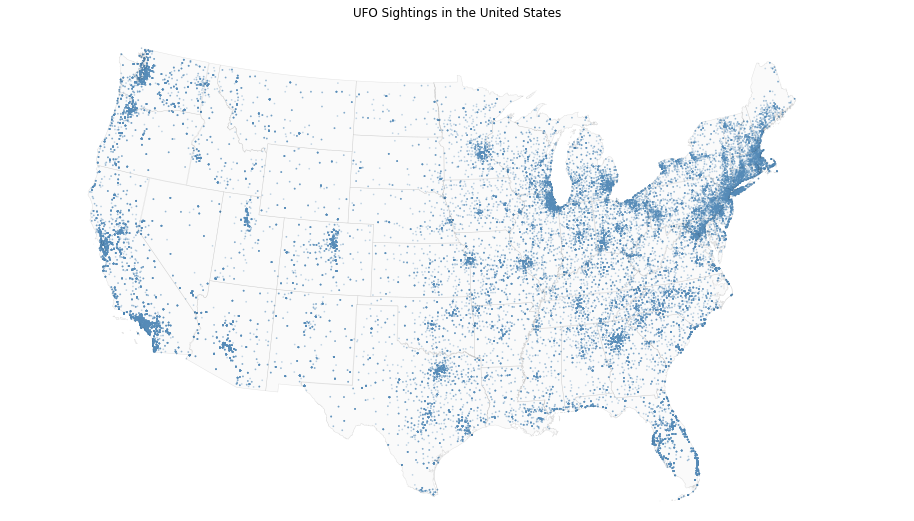

In [7]:
# Albers Equal Area is pretty standard for US projections.
proj = gplt.crs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)

# For some weirdo reason I have to set the ylim manually.
# Reference: http://www.residentmar.io/geoplot/examples/usa-city-elevations.html
ylim = (-1647757.3894385984, 1457718.4893930717)

fig,ax = plt.subplots(subplot_kw={'projection':proj}, figsize=(16,12))
gplt.polyplot(usa, projection=proj,
                   ax=ax,
                   linewidth=0.5,
                   facecolor='lightgray',
                   alpha=0.1)
gplt.pointplot(ufo_sightings_geo, 
               ax=ax, 
               projection=proj, 
               s=0.75,
               alpha=0.25,
               legend=True,
               legend_values=[0, 10, 100, 1000],
               legend_kwargs={'loc':'lower right'})
ax.set_ylim(ylim)
ax.set_title("UFO Sightings in the United States")
plt.show()

Aside from being a pretty cool looking map, there are a couple of pretty clear patterns here.
The sightings seem to be focused into areas with a high population density, which shouldn't be surprising.
The more people there are, the more people present that can report UFOs.
Overall, New England appears to have the highest concentration, with other high-volume areas in southern California, the San Francisco Bay Area, and Pacific Northwest.
Note also that there is an abnormal amount of activity in the Chicago area.
This will come up again later.

**Technical Note**: One word of caution on this map: it's visually oversaturated.
That means the concentration of the points in high density areas isn't correctly represented by just stacking points, which is how the low / medium density areas are represented.
There are more sophisticated plotting libraries that properly deal with this problem - specifically, [datashader](http://datashader.readthedocs.io/en/latest/index.html).
I haven't put in the time to get it to play nice with the plotting library I'm using ([geoplot](http://www.residentmar.io/geoplot/index.html)), but it's worth noting there are good solutions out there.

It's pretty clear these sightings aren't uniformly distributed, but is there a particular reason some areas are highly concentrated?
Well I already mentioned population, but that's _too_ obvious (... and boring).
There has to be more going on here.
A much more interesting (perhaps not much more important) thing to look at would be proximity to United States Air Force bases.
With a pretty small amount of effort I was able to scrape the locations of US military bases from the map on [militarybases.com](https://militarybases.com/).
I went ahead and isolated the bases to US Air Force, but the military bases dataset does have locations for all branches of the military.

In [8]:
import pandas as pd
bases = pd.read_csv('data/external/military_bases.csv')

air_force_bases = \
    bases[bases.branch == 'Air Force']\
    [['branch','latitude','longitude']]\
    .drop_duplicates()\
    .reset_index()\
    .drop('index',axis=1)

So to figure out how many sightings are in close proximity we need to do three things:

1. decide what "close proximity" is,
2. draw a circle around the Air Force bases, and
3. figure out how many UFO sightings happened within the circles.

Now this does disregard certain subtleties like _when_ the bases were established vs the time of sightings, but most of the sightings occurred [after 1998 or so](https://data.world/timothyrenner/ufo-sighting-basics/insights/014547c9-4653-4467-8b26-c10d4e21eeed), so it's probably not a severe approximation.

In [9]:
import pyproj
from toolz import curry
from shapely.ops import transform

# In order to draw a buffer properly I'll need to apply a map projection.
# This is because, unfortunately, the earth isn't flat.
# OR - if it is - we're doing "meters" wrong.
def geographic_buffer(geometry, distance):
    
    # In general picking a map projection amounts to picking the least worst solution.
    # One fairly standard approach is to perform a universal transverse mercator (UTM)
    # projection. The standard definition divides these into zones, but it's easy to
    # recenter the central meridian at the centroid of the geometry (in this case the
    # AF base) and perform the projection there to minimize distance distortion.
    # The lon_0 keyword argument sets the central meridian. Note longitude is x.
    utm = pyproj.Proj(
        proj='utm',
        ellps='WGS84',
        lon_0=geometry.centroid.x
    )
    lonlat = pyproj.Proj(init='EPSG:4326')
    
    utm2lonlat = curry(pyproj.transform)(utm,lonlat)
    lonlat2utm = curry(pyproj.transform)(lonlat,utm)
    
    # First, put the geometry into UTM.
    geometry_utm = transform(lonlat2utm, geometry)
    # Draw the buffer in UTM coordinates, with meters as the units.
    geometry_utm_buffered = geometry_utm.buffer(distance*1000)
    # Transform back into lon/lat.
    geometry_buffered = transform(utm2lonlat, geometry_utm_buffered)
    
    return geometry_buffered
    

In [10]:
from shapely.geometry import Point

air_force_base_vicinities = [
    geographic_buffer(Point(row.longitude, row.latitude), 150.0)
    for _,row in air_force_bases.iterrows()
]

air_force_bases_geo = gpd.GeoDataFrame(
    air_force_bases,
    geometry=air_force_base_vicinities,
    crs={"init": "EPSG:4326"}
)

# Isolate the rows that are inside the continental US.
air_force_bases_geo = \
    air_force_bases_geo[
        air_force_bases_geo.intersects(usa.geometry.cascaded_union)
    ]

Let's take a quick look at the map again, this time with the Air Force bases added.
I've drawn the circles at 150 kilometers from the locations of the bases, which is just under 90 miles.

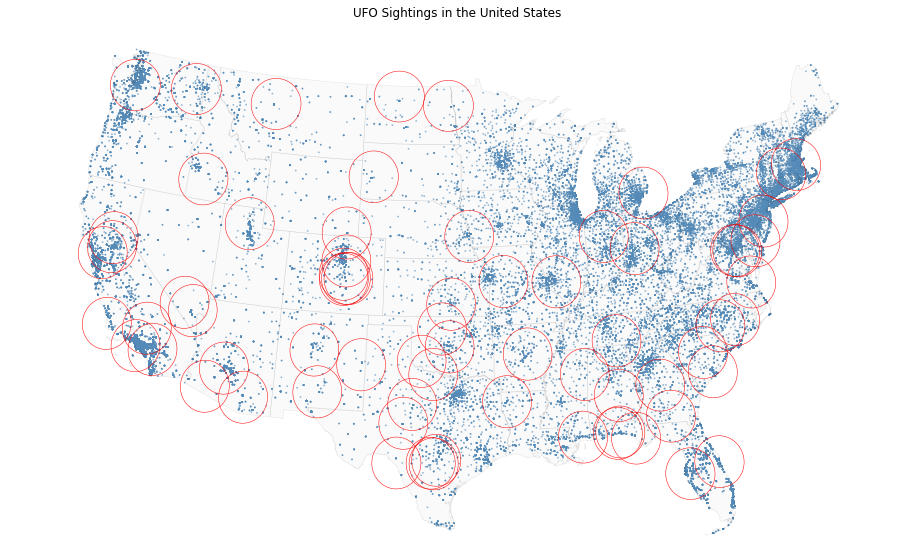

In [11]:
# Albers Equal Area is pretty standard for US projections.
proj = gplt.crs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)

# For some weirdo reason I have to set the ylim manually.
# Reference: http://www.residentmar.io/geoplot/examples/usa-city-elevations.html
fig,ax = plt.subplots(subplot_kw={'projection':proj}, figsize=(16,12))

ylim = (-1647757.3894385984, 1457718.4893930717)
gplt.polyplot(
    usa, 
    projection=proj,
    ax=ax,
    linewidth=0.5,
    facecolor='lightgray',
    alpha=0.1
)
gplt.pointplot(
    ufo_sightings_geo, 
    ax=ax, 
    projection=proj, 
    s=0.75,
    alpha=0.5
)
gplt.polyplot(
    air_force_bases_geo,
    ax=ax, 
    projection=proj, 
    linewidth=0.5,
    facecolor='none',
    edgecolor='red'
)
ax.set_ylim(ylim)
ax.set_title("UFO Sightings in the United States")
plt.show()

That's pretty telling already.
Check out Colorado: the line of bases almost exactly follows the clusters of sightings.
It's pretty obvious in the midwest as well - groups of sightings in Kansas and Nebraska are almost perfectly centered within the circles.
Is it _really_ just that the bases are in population centers, or is there more going on here?

Let's count how many of the sightings are near Air Force bases.

In [12]:
sightings_near_air_force_bases = ufo_sightings_geo.intersects(air_force_bases_geo.geometry.cascaded_union)

print(
    "{:.4f}".format(
        ufo_sightings_geo[sightings_near_air_force_bases].shape[0] / ufo_sightings_geo.shape[0]
    )
)

0.6273


Just over 62% of the UFO sightings in the dataset occur within 150 kilometers of an Air Force base.
Well I think I can safely and unscientifically declare a substantial number of these solved.

![](air_force.jpg)

You're welcome.

Well now we have a sort-of correlating factor for at least some of the varying geographic density.
Is there a similar pattern that pops out when we look at the sightings by day?

In [13]:
# Add the date of the sighting.
ufo_sightings_geo.loc[:,'date'] = \
    gpd.pd.to_datetime(ufo_sightings_geo.date_time).dt.to_period("D")

sightings_by_day = \
    ufo_sightings_geo\
        .groupby('date')\
        .agg({'report_link':'count'})\
        .rename(columns={'report_link':'report_count'})

sightings_by_day.loc[:,'day_of_year'] = sightings_by_day.index.dayofyear

sightings_by_day_of_year = \
    sightings_by_day\
        .groupby('day_of_year')\
        .agg({'report_count':'sum'})\
        .reset_index()

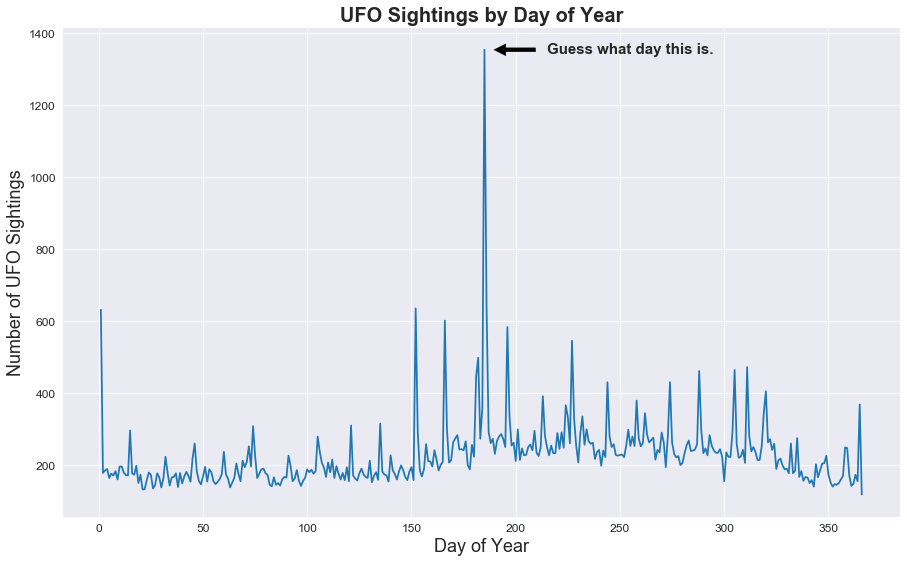

In [14]:
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context("notebook")

fig,ax = plt.subplots(figsize=(15,9))

ax.plot(
    sightings_by_day_of_year.day_of_year.values,
    sightings_by_day_of_year.report_count
)

ax.set_title(
    "UFO Sightings by Day of Year", 
    fontsize=20, 
    fontweight="bold"
)
ax.set_xlabel(
    "Day of Year",
    fontsize=18
)
ax.set_ylabel(
    "Number of UFO Sightings",
    fontsize=18
)

ax.annotate(
    "Guess what day this is.",
    xy=(185, 1353),
    xytext=(215, 1353),
    arrowprops={
        "facecolor": "black",
        "shrink": 0.15
    },
    verticalalignment="center",
    fontsize=15,
    fontweight="bold"
)

ax.tick_params(labelsize=12, which='both')

plt.show()

Okay so a lot of sightings occur on the fourth of July, and a lot of sightings occur near Air Force bases, but what about specific events?
Is it possible to correlate sightings both spatially _and_ temporally to see if we can find a reasonable number of reports that are all pointing to the same object?
I'll tackle this one in two parts: first I need to spatially segment the sightings.
I _could_ just group by city, but a lot of the "cities" are actually more like suburbs, so they're pretty close together.
An object flying through the sky would be visible across several cities, and the farther it flies the more likely it is to be spotted in more than one city.

Better than looking at the individual city level would be to find groups of closely packed sightings based on location, then within those groups look for sightings on the same day.
We can find these groups of sightings using a clustering algorithm, which automatically groups the sightings based on their location and geographic density.
The particular algorithm I'll use is called [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/).
I'm not going into the details about how it works but it is very well suited to clustering this dataset based on the breadth of total area and the highly varying density of the points.

In [17]:
import hdbscan

ufo_sighting_coordinates = np.radians(ufo_sightings_geo.loc[:,['latitude', 'longitude']].values)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50, 
    min_samples=1,
    metric="haversine", 
    cluster_selection_method='leaf'
)

# This will take a while.
ufo_sightings_geo.loc[:,'cluster_label'] = clusterer.fit_predict(ufo_sighting_coordinates)

In [16]:
print("Total number of clusters: {}.".format(ufo_sightings_geo.cluster_label.max()))

Total number of clusters: 578.


The algorithm itself only assigns labels to points - all we need to do to get a look at the concentrated sighting areas is to draw shapes around them.

In [18]:
cluster_polygons = \
    [
        MultiPoint(group.loc[:,['longitude', 'latitude']].values).convex_hull
        for label,group in ufo_sightings_geo.groupby('cluster_label')
        if label != -1
    ]

Okay, here's what the sightings look like with the dense areas overlaid.

In [ ]:
# Albers Equal Area is pretty standard for US projections.
proj = gplt.crs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)

# For some weirdo reason I have to set the ylim manually.
# Reference: http://www.residentmar.io/geoplot/examples/usa-city-elevations.html
fig,ax = plt.subplots(subplot_kw={'projection':proj}, figsize=(16,12))

ylim = (-1647757.3894385984, 1457718.4893930717)
gplt.polyplot(
    usa, 
    projection=proj,
    ax=ax,
    linewidth=0.5,
    facecolor='lightgray',
    alpha=0.1
)
gplt.polyplot(
    gpd.GeoSeries(
        [p for p in cluster_polygons if p.type == "Polygon"], 
        crs={"init": "EPSG:4326"}
    ),
    ax=ax,
    projection=proj,
    linewidth=0.5,
    facecolor='red',
    alpha=0.3
)
gplt.pointplot(
    ufo_sightings_geo, 
    ax=ax, 
    projection=proj, 
    s=0.75,
    alpha=0.5
)
ax.set_ylim(ylim)
ax.set_title("UFO Sightings in the United States")
plt.show()

It looks like the clustering is solid.
Even the really dense areas have clusters, but it's hard to see them because they're pretty small.

One thing to note is tht outliers are getting classified even in "globally" dense areas.
This is something of a philosophical question: if you assume that _some_ of the points in any area are noisy, then you really want the highest concentration within that area, which is what HDBSCAN does.
On the other hand there are a pretty good number of outliers here.
The algorithm isn't designed to assign _every_ point to a cluster, only the ones in highly dense points.
So what do we do?
Well, we can layer on some assignment.
If we take each outlier and assign it to the nearest cluster the polygons can be redrawn to cover all of the points.

In [ ]:
import rtree

def cluster_polygon_loader(polygons):
    for ii,polygon in enumerate(polygons):
        yield (ii, polygon.bounds, ii)

polygon_index = rtree.index.Index(
    cluster_polygon_loader(cluster_polygons)
)

In [ ]:
def nearest_cluster(lon,lat):
    return list(polygon_index.nearest((lon,lat)*2, 1))[0]

ufo_sightings_geo.loc[:,'cluster_label_neighbor'] = np.array([
    nearest_cluster(row.longitude, row.latitude) 
    for _,row in ufo_sightings_geo.iterrows()
])

Now redraw the polygons.

In [ ]:
cluster_polygons_neighbors = \
    [
        MultiPoint(group.loc[:,['longitude', 'latitude']].values).convex_hull
        for label,group in ufo_sightings_geo.groupby('cluster_label_neighbor')
        if label != -1
    ]

In [ ]:
# Albers Equal Area is pretty standard for US projections.
proj = gplt.crs.AlbersEqualArea(central_longitude=-98, central_latitude=39.5)

# For some weirdo reason I have to set the ylim manually.
# Reference: http://www.residentmar.io/geoplot/examples/usa-city-elevations.html
fig,ax = plt.subplots(subplot_kw={'projection':proj}, figsize=(16,12))

ylim = (-1647757.3894385984, 1457718.4893930717)
gplt.polyplot(
    usa, 
    projection=proj,
    ax=ax,
    linewidth=0.5,
    facecolor='lightgray',
    alpha=0.1
)
gplt.polyplot(
    gpd.GeoSeries(
        [p for p in cluster_polygons_neighbors 
           if p.type == "Polygon"], 
        crs={"init": "EPSG:4326"}
    ).intersection(
        usa.geometry.cascaded_union
    ),
    ax=ax,
    projection=proj,
    linewidth=0.5,
    facecolor='red',
    alpha=0.3
)
gplt.pointplot(
    ufo_sightings_geo, 
    ax=ax, 
    projection=proj, 
    s=0.75,
    alpha=0.5
)
ax.set_ylim(ylim)
ax.set_title("UFO Sightings in the United States")
plt.show()

The next step is to group the sightings by the clusters.
Then we'll be able to see which clusters contain multiple sightings on the same day.

Now's the part where I put on my tin foil hat and embark on some grandiose theory that relates the UFOs to the military bases to what's clearly a government cover up for distributing autism causing vaccines through chemical trails but just at night to get you ready to squint really hard at the data to make it _seem_ like a group of reports is all describing the same thing.

But I'm not going to do that because I don't have to.

In [ ]:
non_outlier_sightings = ufo_sightings_geo.cluster_label != -1

same_day_cluster_sightings = gpd.pd.concat(
    [    
        cluster_sightings\
            .groupby(['cluster_label','date'])\
            .agg({'report_link':'count'})\
            .reset_index()\
            .rename(columns={'report_link':'report_count'})\
            .query('report_count>1')
        for cluster_label, cluster_sightings 
        in ufo_sightings_geo[non_outlier_sightings].groupby('cluster_label')
    ]
).sort_values('report_count', ascending=False)

same_day_cluster_sightings.head(n=10)

On October 31st, 2004 there were _fifty seven_ reports within the same small geographic area on the same day.
These reports are collected voluntarily - it's likely thousands of people saw something that night.
_Bonus note: There are 31 sightings on August 21, 2004 in the same place (check the cluster label)._
The cluster covers a small suburb of Chicago called Tinley Park.

Here's what they saw.

In [ ]:
same_day = ufo_sightings_geo.date == same_day_cluster_sightings.iloc[0].date
same_cluster = ufo_sightings_geo.cluster_label == same_day_cluster_sightings.iloc[0].cluster_label
for _,row in ufo_sightings_geo[same_day & same_cluster].iloc[:10,].iterrows():
    print("{}, {} {}".format(row.city, row.state, row.date))
    print(row.text)
    print()

Freaked out yet?
These people are all describing the same thing: three red lights in formation in the sky.
While it's not clear what the cause of the lights actually was, you'd have to work pretty hard to convince me all these people are making this up or embellishing something ordinary.
Enough people thought it was weird enough to report it, and we can easily assume that many many more saw them without reporting them to NUFORC because, let's be real, you probably hadn't heard of NUFORC before you started reading.
The mass sighting in August has reports of the same thing: three red lights.

Did anybody get a picture of this thing?
Oh yeah - here's a picture of them, hosted on the NUFORC site:
![](http://www.nuforc.org/CB103104.jpg)

"Alright Frohike hit me again." - you got it Dr. Scully.

In [ ]:
same_day = ufo_sightings_geo.date == same_day_cluster_sightings.iloc[2].date
same_cluster = ufo_sightings_geo.cluster_label == same_day_cluster_sightings.iloc[2].cluster_label
for _,row in ufo_sightings_geo[same_day & same_cluster].iloc[:10,].iterrows():
    print("{}, {} {}".format(row.city, row.state, row.date))
    print(row.text)
    print()

Rockford, IL 2001: over 20 people reported (far more probably saw) 10 or so yellow / orange lights in the sky, flying in some non-random formation.
I googled around a little bit but couldn't find much about this specific sighting, but I did learn that UFO sightings aren't all that uncommon in the Rockford area either.
It's only about 2 hours away from Tinley Park.
I'd also like to point out that Tinley Park and Rockford sightings are _not_ in the vicinity of a nearby Air Force base.
Check the map plot with the Air Force bases if you don't believe me.

Oh and yes I can keep going Agent Mulder:

In [ ]:
same_day = pd.PeriodIndex(ufo_sightings_geo.date) == pd.to_datetime('1997-03-13')
same_city = ufo_sightings_geo.city == "Phoenix"

for _,row in ufo_sightings_geo[same_day & same_city].iloc[:10,].iterrows():
    print("{}, {} {}".format(row.city, row.state, row.date))
    print(row.text)
    print()

Phoenix Arizona, 1997.
[Google](http://lmgtfy.com/?q=phoenix+lights) this one.
[Read up](https://en.wikipedia.org/wiki/Phoenix_Lights), wake up folks.
It's probably the most famous mass sighting in recent history.

A _huge_ number of people saw a cluster of lights in a V formation flying over Phoenix for several hundred miles.
Don't believe me?
There's a photo.

![](https://www.gannett-cdn.com/-mm-/c874ad012946e9810f89cfbf35e0d07a60863a97/c=1-0-540-405&r=x404&c=534x401/local/-/media/2017/02/17/Phoenix/Phoenix/636229502332893938-lynnketeiphoenixlightshost.jpg)

Official reports by the Air Force - not released for _months_ afterwards - stated that a group of A-10 planes were flying over the region dropping flares.

While I wouldn't take this as a 100% locked down explanation, I was able to show that a substantial number of UFO sightings occurred within a relatively short distance (from an aircraft perspective) from a US Air Force base.
I also showed that a hilariously large number of UFO sightings tend to occur on the fourth of July.
That one's not as straightforward as it looks - it could be fireworks, but also everyone's outside at night looking at the sky.

Drinking.

Okay maybe it is pretty straightforward.

Not so straightforward were the mass sightings that occur in the dataset.
I focused on Tinley Park, Rockford, and Carteret, but there are a lot more in this dataset.
You can check out the notebook on GitHub and look at more of these yourself if you're so inclined.

Well that's all I've got for now.
Other things worth exploring are actually doing my due diligence on the whole population thing, incorporating weather and visibility conditions and other stuff I haven't thought of yet.
Right now though there's been this cable company van hanging out across the street from my house so I need to go ask what they want.